In [1]:
%load_ext autoreload
%autoreload 2

### Load Example Series

In [2]:
from hc11_functions import Tarloader

# Make Dataloader
tl = Tarloader('./data/hc-11/data/')
# Can also extract to alternative directories
# tl = Tarloader(tar_directory='./data/hc-11/data/', export_directory='./data/hc-11/export/')

# Get session 2 (Will extract files if required)
print(f'tl contains {len(tl)} sessions')
print(tl.files)
dl = tl['Buddy_06272013']  # Equivalent to tl[2]

# Get group 2 (Will compile files if required)
print(f'dl contains {len(dl)} groups')
novel, data = dl[1]

tl contains 8 sessions
['Achilles_10252013', 'Achilles_11012013', 'Buddy_06272013', 'Cicero_09012014', 'Cicero_09102014', 'Cicero_09172014', 'Gatsby_08022013', 'Gatsby_08282013']
dl contains 16 groups


### Process Data

In [3]:
import numpy as np
import pandas as pd
from tqdm import tqdm

# Params
delta = 5  # Sample every _ seconds

# Create df
feature_columns = list(data.iloc[:, 3:].columns)
df = pd.DataFrame(columns=['time', 'position']+feature_columns)

# Process rows
timestamp = 0
data_max = data['time'].max()
novel_max = novel['sessInfo']['Position']['TimeStamps'].max()
while timestamp < max(data_max, novel_max):
    # Get index of closest time from data
    if not timestamp - delta > data_max:
        idx = np.argmin(np.abs(data['time'] - timestamp))
        features = data[feature_columns].loc[idx]

    # Get index of closest time from novel
    if not timestamp - delta > novel_max:
        idx = np.argmin(np.abs(novel['sessInfo']['Position']['TimeStamps'] - timestamp))
        position = novel['sessInfo']['Position']['OneDLocation'][idx]

    # Append to df
    df.loc[df.shape[0]] = [timestamp, position] + list(features)

    # Iterate timestamp
    timestamp += delta

### Plot Series

In [4]:
from scipy.stats import pearsonr

# Calculate correlations
feature_columns_filtered = [
    col
    for col in feature_columns
    if not pd.isna(df.loc[~pd.isna(df['position'])][col]).any()
]
correlations = [
    pearsonr(
        df.loc[~pd.isna(df['position'])][col].to_numpy(),
        df.loc[~pd.isna(df['position'])]['position'].to_numpy())
        for col in feature_columns_filtered
    ]
correlations, ps = zip(*correlations)

# Get max correlating feature/wf
max_idx = np.argmax(correlations)
max_col = feature_columns_filtered[max_idx]
print(f'Feature \'{max_col}\' had a correlation of {correlations[max_idx]} (p={ps[max_idx]})')

Feature 'wf47' had a correlation of 0.3990153445953388 (p=0.017575466352238063)


C:\Users\nck\AppData\Local\Temp\ipykernel_21980\1487043496.py:11: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs['A'].get_shared_x_axes().join(axs['A'], axs['B'])
C:\Users\nck\AppData\Local\Temp\ipykernel_21980\1487043496.py:12: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs['C'].get_shared_x_axes().join(axs['C'], axs['D'])


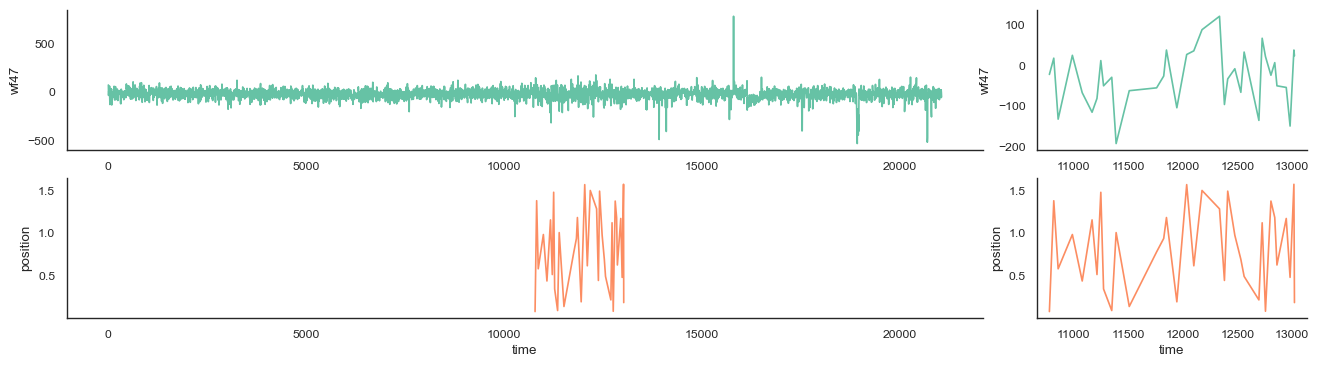

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context='paper', style='white', palette='Set2')

# Options
feature_col = max_col

# Plot subsampled series
fig = plt.figure(figsize=(16, 4))
axs = fig.subplot_mosaic('AAAD;BBBC')
axs['A'].get_shared_x_axes().join(axs['A'], axs['B'])
axs['C'].get_shared_x_axes().join(axs['C'], axs['D'])
# Ephys data
sns.lineplot(data=df, x='time', y=feature_col, ax=axs['A'])
sns.despine(ax=axs['A'])
axs['A'].set_xlabel(None)
# Ephys zoom
sns.lineplot(data=df.loc[~pd.isna(df['position'])], x='time', y=feature_col, ax=axs['D'])
sns.despine(ax=axs['D'])
axs['D'].set_xlabel(None)
# Location data
sns.lineplot(data=df, x='time', y='position', color=sns.color_palette()[1], ax=axs['B'])
sns.despine(ax=axs['B'])
# Location zoom
sns.lineplot(data=df.loc[~pd.isna(df['position'])], x='time', y='position', color=sns.color_palette()[1], ax=axs['C'])
sns.despine(ax=axs['C'])